In [82]:
import numpy as np
import pandas as pd
import os
from importlib import reload
import find_cpt
from rgf.sklearn import RGFClassifier, FastRGFClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# data_dir = "./data-2015"
data_dirs = ['./data-2014/', './data-2015/']
# model_name = 'ST4000DM000'
# model_name = 'ST31500541AS'
model_name = 'Hitachi HDS722020ALA330'
# model_name = 'Hitachi HDS5C3030ALA630'

In [67]:
test = pd.read_csv('./data-2015/2015-01-01.csv')
all_features = list(test.loc[test['model'] == model_name].dropna(axis=1, how='all').columns.values)
def process_SgtA(df, name):
    df = df.loc[df['model'] == name]
    return df[all_features]
type_dict = {feature: np.float32 for feature in all_features[5:]}
SgtA = pd.concat([process_SgtA(pd.read_csv(os.path.join(data_dir, filename), dtype=type_dict), model_name) for data_dir in data_dirs for filename in os.listdir(data_dir)])

In [68]:
# find names of the failure disk
fail_names = SgtA.loc[SgtA['failure'] == 1]['serial_number'].unique()
print(model_name)
print('n_disks: ' + str(SgtA['serial_number'].unique().size))
print('n_failed: ' + str(fail_names.size))
print('failed_percent: '  + str(fail_names.size / SgtA['serial_number'].unique().size))

ST4000DM000
n_disks: 29908
n_failed: 824
failed_percent: 0.027551156881102046


Hitachi HDS722020ALA330
n_disks: 4737
n_failed: 159
failed_percent: 0.03356554781507283

Hitachi HDS5C3030ALA630
n_disks: 4634
n_failed: 74
failed_percent: 0.015968925334484248

ST4000DM000
n_disks: 29908
n_failed: 824
failed_percent: 0.027551156881102046

ST31500541AS
n_disks: 1970
n_failed: 271
failed_percent: 0.13756345177664975

In [69]:
# find failure disks
failure_disk_group = SgtA.loc[SgtA['serial_number'].isin(fail_names)].sort_values('date', ascending=True).groupby('serial_number')

def get_cpt(data):
    changepoint = find_cpt.cpt(data=data, type='normal-mean').find_changepoint()
    if changepoint > 0:
        return data.size - changepoint
    return changepoint

functions_group = {n: get_cpt for n in all_features[5:]}
all_cpt_series = failure_disk_group.agg(functions_group)
# print(all_cpt_series)

In [70]:
all_cpt_series.to_csv('./preprocess/' + model_name + '_cpt.csv')
def get_percent(data):
    return data[(data>0) & (data <=100)].dropna().size/data.dropna().size
def get_median(data):
    return data[data>0].dropna().median()
def get_mean(data):
    return data[data>0].dropna().mean()
summarize = all_cpt_series.agg([get_percent, get_median, get_mean])
# print(summarize)
summarize.to_csv('./preprocess/' + model_name + '_summarize.csv')

In [71]:
selected_features = summarize.loc['get_percent'].T.sort_values(ascending=False)
selected_features = selected_features[selected_features>0.01]
selected_features.to_csv('./preprocess/' + model_name + '_selected_features.csv')
print(selected_features.head())
selected_features = selected_features.index
irrelevent_features = ['smart_9_raw', 'smart_9_normalized', 'smart_4_raw', 'smart_4_normalized', 'smart_12_raw', 'smart_12_normalized']
selected_features = [i for i in selected_features if i not in irrelevent_features]
print(selected_features)

smart_193_raw    0.442961
smart_197_raw    0.429612
smart_198_raw    0.417476
smart_194_raw    0.411408
smart_7_raw      0.405340
Name: get_percent, dtype: float64
['smart_193_raw', 'smart_197_raw', 'smart_198_raw', 'smart_194_raw', 'smart_7_raw', 'smart_190_raw', 'smart_190_normalized', 'smart_194_normalized', 'smart_187_raw', 'smart_187_normalized', 'smart_242_raw', 'smart_240_raw', 'smart_193_normalized', 'smart_7_normalized', 'smart_1_normalized', 'smart_241_raw', 'smart_1_raw', 'smart_3_normalized', 'smart_5_raw', 'smart_192_raw', 'smart_189_raw', 'smart_189_normalized', 'smart_5_normalized', 'smart_197_normalized', 'smart_198_normalized', 'smart_188_raw', 'smart_183_raw', 'smart_183_normalized', 'smart_184_raw', 'smart_184_normalized', 'smart_199_raw']


In [72]:
Sgt_features = ['serial_number', 'date', 'smart_1_normalized', 'smart_1_raw', 'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized', 'smart_7_raw',
    'smart_184_normalized', 'smart_184_raw', 'smart_187_normalized', 'smart_187_raw', 'smart_188_raw', 'smart_189_normalized', 'smart_189_raw', 
    'smart_190_normalized', 'smart_190_raw', 'smart_193_normalized', 'smart_193_raw', 'smart_194_normalized', 'smart_194_raw', 'smart_197_normalized', 
    'smart_197_raw', 'smart_198_normalized', 'smart_198_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'failure']
# new_features = [i for i in selected_features if i not in Sgt_features]
new_features = [i for i in selected_features if i not in Sgt_features]
print(new_features)

['smart_3_normalized', 'smart_192_raw', 'smart_183_raw', 'smart_183_normalized', 'smart_199_raw']


In [73]:
# compact info.
def get_cmpt_info(data):
    return pd.ewma(data.values, span=np.round(summarize.loc['get_median', data.name]))[-1]
functions_group1 = {n: get_cmpt_info for n in selected_features}
# print(functions_group1)
compacted_info = SgtA.groupby('serial_number', as_index=False).agg(functions_group1)
compacted_info['failure'] = compacted_info.apply(lambda row: 1 if row['serial_number'] in fail_names else 0, axis=1)
# print(compacted_info)
compacted_info.to_csv('./preprocess/' + model_name + '_compacted.csv')

C:\Users\Ray\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
# kmeans
# prepare set
compacted_info = pd.read_csv('./preprocess/' + model_name + '_compacted.csv').iloc[:, 1:]
compacted_info = compacted_info.dropna(how='any')
fail_names = compacted_info.loc[compacted_info['failure'] == 1]['serial_number'].unique()
n_clusters = fail_names.size // 5
X_health = compacted_info.loc[compacted_info['failure'] == 1].drop(['serial_number', 'failure'], axis=1).values
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_jobs=-1).fit(X_health)

In [71]:
X_health_transformed = []
for j in range(0, n_clusters):
    d = kmeans.transform(X_health)[:, j]
    ind = np.argsort(d)[::-1][:10]
    X_health_transformed[0:0] = list(X_health[ind])

In [72]:
X_failed = list(compacted_info.loc[compacted_info['failure'] == 1].drop(['serial_number', 'failure'], axis=1).values)
X = np.array(X_health_transformed + X_failed)
y = np.concatenate((np.zeros(len(X_health_transformed)), np.ones(len(X_failed))), axis=0) 
print(X.shape)
print(y.shape)

(454, 24)
(454,)


In [73]:
def model_stat(model, X, y):
    f_score = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1)
    r_score = cross_val_score(model, X, y, cv=5, scoring='recall', n_jobs=-1)
    p_score = cross_val_score(model, X, y, cv=5, scoring='precision', n_jobs=-1)
    return pd.Series({'P': np.mean(p_score), 'R': np.mean(r_score), 'F': np.mean(f_score), 'Sd': np.std(f_score)})

statics = pd.DataFrame(index=['GBDT', 'SVM', 'DT', 'LR', 'RF', 'RGF'], columns=['P', 'R', 'F', 'Sd'])
statics

,P,R,F,Sd
GBDT,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN
DT,NaN,NaN,NaN,NaN
LR,NaN,NaN,NaN,NaN
RF,NaN,NaN,NaN,NaN
RGF,NaN,NaN,NaN,NaN


In [74]:
search_grid = {
    'C': np.linspace(0.1, 0.5, 10),
    'class_weight': ['balanced'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

lr_model = LogisticRegression()
lr_grid = GridSearchCV(estimator=lr_model, param_grid=search_grid, 
    cv=5, scoring='f1', n_jobs=-1, verbose=2)

lr_grid.fit(X, y)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

statics.loc['LR'] = model_stat(lr_grid.best_estimator_, X, y)
statics.loc['LR']

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.6s finished
C:\Users\Ray\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Ray\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Ray\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


0.7654772029832607
{'C': 0.1, 'class_weight': 'balanced', 'solver': 'newton-cg'}


P      0.709357
R      0.851183
F       0.76521
Sd    0.0766611
Name: LR, dtype: object

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


0.9111214310908181
{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 13, 'random_state': 0}
Feature ranking:
1. feature 1 (0.290904)
2. feature 0 (0.123309)
3. feature 3 (0.092247)
4. feature 2 (0.088209)
5. feature 11 (0.051055)
6. feature 9 (0.046388)
7. feature 4 (0.043220)
8. feature 6 (0.042248)
9. feature 8 (0.038573)
10. feature 10 (0.034211)
11. feature 7 (0.034075)
12. feature 5 (0.033440)
13. feature 15 (0.024409)
14. feature 12 (0.012663)
15. feature 17 (0.011968)
16. feature 18 (0.009480)
17. feature 22 (0.006685)
18. feature 20 (0.005437)
19. feature 14 (0.004314)
20. feature 21 (0.003509)
21. feature 19 (0.001748)
22. feature 16 (0.001720)
23. feature 23 (0.000187)
24. feature 13 (0.000000)


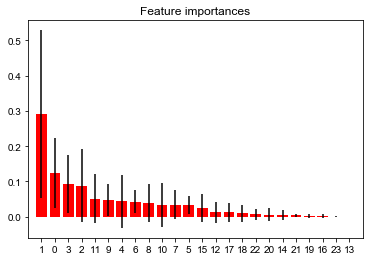

P      0.986207
R      0.850968
F      0.911131
Sd    0.0436708
Name: RF, dtype: object

In [83]:
# tune RF
n_estimators = [13] # tuned
max_features = ['auto'] # tuned
criterion = ['entropy']  # tuned
max_depth = [18] # tuned
min_samples_split = [2]
min_samples_leaf = [1]
min_weight_fraction_leaf = [0]
max_leaf_nodes = [None]

bootstrap = [False]
random_state = [0]
class_weight = ['balanced']
search_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'min_weight_fraction_leaf': min_weight_fraction_leaf,
    'max_leaf_nodes': max_leaf_nodes,
    'bootstrap': bootstrap,
    'random_state': random_state,
    'class_weight': class_weight
    }

rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf_model, param_grid=search_grid, 
    cv=5, scoring='f1', n_jobs=-1, verbose=2)

rf_grid.fit(X, y)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

statics.loc['RF'] = model_stat(rf_grid.best_estimator_, X, y)
statics.loc['RF']

In [76]:
# tune SVM
search_grid = {
    'C': [1.05], 
    'kernel': ['rbf'],
    'gamma': [0.05],
    'class_weight': ['balanced'],
    'max_iter': [-1],
    'random_state': [0]
}
svm_model = SVC()
svm_grid = GridSearchCV(estimator=svm_model, param_grid=search_grid, 
    cv=5, scoring='f1', n_jobs=-1, verbose=2)
svm_grid.fit(X, y)

print(svm_grid.best_score_)
print(svm_grid.best_params_)
statics.loc['SVM'] = model_stat(svm_grid.best_estimator_, X, y)
statics.loc['SVM']


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


0.8879203479050414
{'C': 1.05, 'class_weight': 'balanced', 'gamma': 0.05, 'kernel': 'rbf', 'max_iter': -1, 'random_state': 0}


P      0.927273
R      0.870538
F      0.887632
Sd    0.0740392
Name: SVM, dtype: object

In [77]:
# tune GBDT
search_grid = {
    'n_estimators': [169],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_depth': [8],
    'max_features':['sqrt'],
    'subsample': [0.93],
    'random_state': [0]
}
gbdt_model = GradientBoostingClassifier()
gbdt_grid = GridSearchCV(estimator= gbdt_model, param_grid=search_grid, 
    cv=5, scoring='f1', n_jobs=-1, verbose=2)
gbdt_grid.fit(X, y)

print(gbdt_grid.best_score_)
print(gbdt_grid.best_params_)

statics.loc['GBDT'] = model_stat(gbdt_grid.best_estimator_, X, y)
statics.loc['GBDT']

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


0.9151562729009901
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 169, 'random_state': 0, 'subsample': 0.93}


P      0.986207
R      0.857419
F      0.915156
Sd    0.0407769
Name: GBDT, dtype: object

In [78]:
# tune DT (TBI)
search_grid = {
    'criterion': ['entropy'],
    'min_samples_split': [2],
    'min_samples_leaf': [15],
    'max_depth': [8],
    'max_features':['sqrt'],
    'class_weight': ['balanced'],
    'random_state': [0]
}
dt_model = DecisionTreeClassifier()
dt_grid = GridSearchCV(estimator= dt_model, param_grid=search_grid, 
    cv=5, scoring='f1', n_jobs=3, verbose=2)
dt_grid.fit(X, y)
print(dt_grid.best_score_)
print(dt_grid.best_params_)

statics.loc['DT'] = model_stat(dt_grid.best_estimator_, X, y)
statics.loc['DT']

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.1s finished


0.8554510846884993
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 2, 'random_state': 0}


P       0.88536
R      0.857849
F      0.855107
Sd    0.0935921
Name: DT, dtype: object

In [79]:
# tune RGF
search_grid = {
    'max_leaf': [2000],
    'algorithm': ['RGF_Sib'],
    'test_interval': [50],
    'loss': ['Log']
}
# loss: You can select "LS", "Log", "Expo" or "Abs".
rgf_model = RGFClassifier()
# rgf_model = FastRGFClassifier()
rgf_grid = GridSearchCV(estimator= rgf_model, param_grid=search_grid, 
    cv=5, scoring='f1', n_jobs=3, verbose=2)
rgf_grid.fit(X, y)
print(rgf_grid.best_score_)
print(rgf_grid.best_params_)

statics.loc['RGF'] = model_stat(rgf_grid.best_estimator_, X, y)
statics.loc['RGF']

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.1s finished


0.9111214310908181
{'algorithm': 'RGF_Sib', 'loss': 'Log', 'max_leaf': 2000, 'test_interval': 50}


P      0.986207
R      0.850968
F      0.911131
Sd    0.0436708
Name: RGF, dtype: object

In [80]:
statics.T.to_csv('./preprocess/' + model_name +'_finalstatics.csv')
statics.T

,GBDT,SVM,DT,LR,RF,RGF
P,0.986207,0.927273,0.88536,0.709357,0.986207,0.986207
R,0.857419,0.870538,0.857849,0.851183,0.850968,0.850968
F,0.915156,0.887632,0.855107,0.76521,0.911131,0.911131
Sd,0.0407769,0.0740392,0.0935921,0.0766611,0.0436708,0.0436708
